In [3]:
# All the libraries used for the project
#Libraries needed for reading the data and building a Neural Network Classifier
%matplotlib inline
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Rescaling, GlobalAveragePooling2D 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam
from matplotlib.image import imread
import matplotlib.pyplot as plt
import itertools, collections
from tensorflow import keras
from tensorflow.keras import optimizers
import tensorflow as tf
from keras import models
from keras import layers
import sys
import datetime
import glob as glob
import ast



# from preprocessing_multi_CNN import Train_Validation_Test_Split

import pickle as pk

import cv2 
# from keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import VGG19

import seaborn as sns
import pandas as pd
import numpy as np
import pathlib
import random
import os

# print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
# print("Tensorflow version: " + tf.__version__)

In [4]:
#define height and width of the image
img_width=96; img_height=96
nb_epochs = 10
#number of batches the data has to be divided into
batch_size=64


In [5]:
#define directory containing training data
TRAINING_DIR = 'dataset/train'
#create generator to load the data from training directory
train_generator = ImageDataGenerator().flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))


Found 12677 images belonging to 8 classes.


In [6]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(TRAINING_DIR):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)


12677


In [7]:
#define directory containing validation data
VALIDATION_DIR = 'dataset/val'

#create generator to load the data from validation directory
validation_generator = ImageDataGenerator().flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 3622 images belonging to 8 classes.


In [8]:
# get number of images in validation directory
nb_val_samples = 0
for r, dirs, files in os.walk(VALIDATION_DIR):
    for dr in dirs:
        nb_val_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_val_samples)


3622


In [9]:
#define directory containing testing data
TEST_DIR = 'dataset/test'

#create generator to load the data from testing directory
test_generator = ImageDataGenerator().flow_from_directory(TEST_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width),
                                                          shuffle=False 
                                                             )

Found 1819 images belonging to 8 classes.


In [10]:
# get number of images in test directory
nb_test_samples = 0
for r, dirs, files in os.walk(TEST_DIR):
    for dr in dirs:
        nb_test_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_test_samples)


1819


In [11]:
input_shape = (img_height, img_width, 3)

n_steps_per_epoch = int(nb_train_samples / batch_size)
n_validation_steps = int(nb_val_samples / batch_size)
n_test_steps = int(nb_test_samples / batch_size)

print('Input Shape: '+'('+str(img_height)+', '+str(img_width)+', ' + str(3)+')')
print('Batch Size: ' + str(batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print()
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(nb_epochs))
print()
# print('Number of Classes: ' + str(num_classes))

Input Shape: (96, 96, 3)
Batch Size: 64

Steps per Epoch: 198

Validation Steps: 56

Test Steps: 28

Number of Epochs: 5



## Visualize data distribution

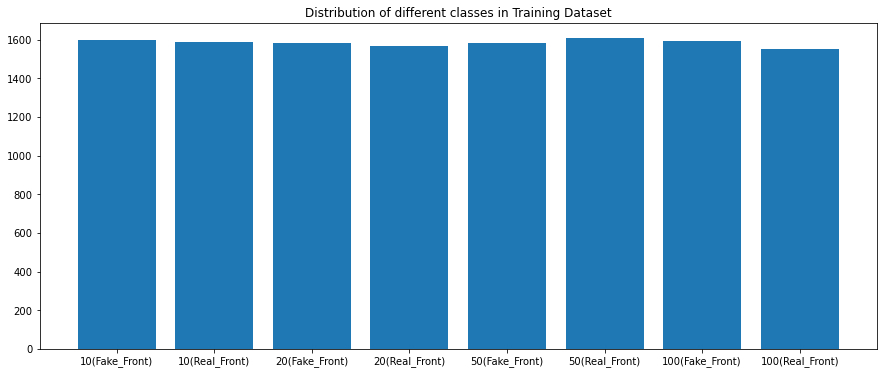

In [10]:
image_folder = ['10(Fake_Front)','10(Real_Front)','20(Fake_Front)','20(Real_Front)','50(Fake_Front)','50(Real_Front)','100(Fake_Front)','100(Real_Front)']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('dataset/train/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(15, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()


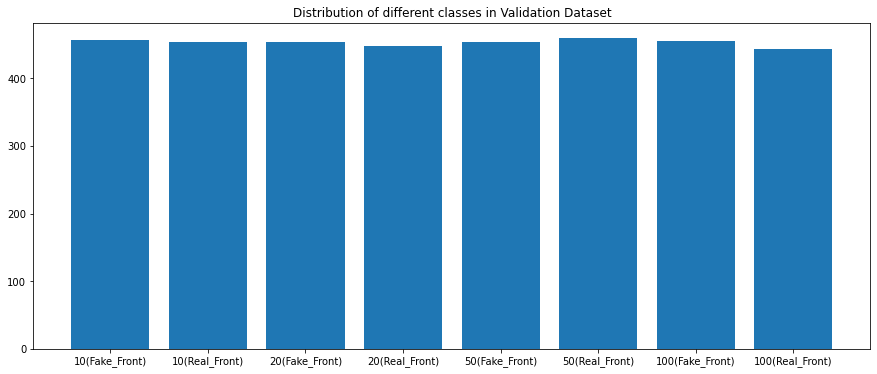

In [11]:
image_folder = ['10(Fake_Front)','10(Real_Front)','20(Fake_Front)','20(Real_Front)','50(Fake_Front)','50(Real_Front)','100(Fake_Front)','100(Real_Front)']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('dataset/val/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(15, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Validation Dataset')
plt.show()

In [12]:
# We save the list of classes (labels).
class_names = list(train_generator.class_indices.keys())

# We also save the number of labels.
num_classes = train_generator.num_classes

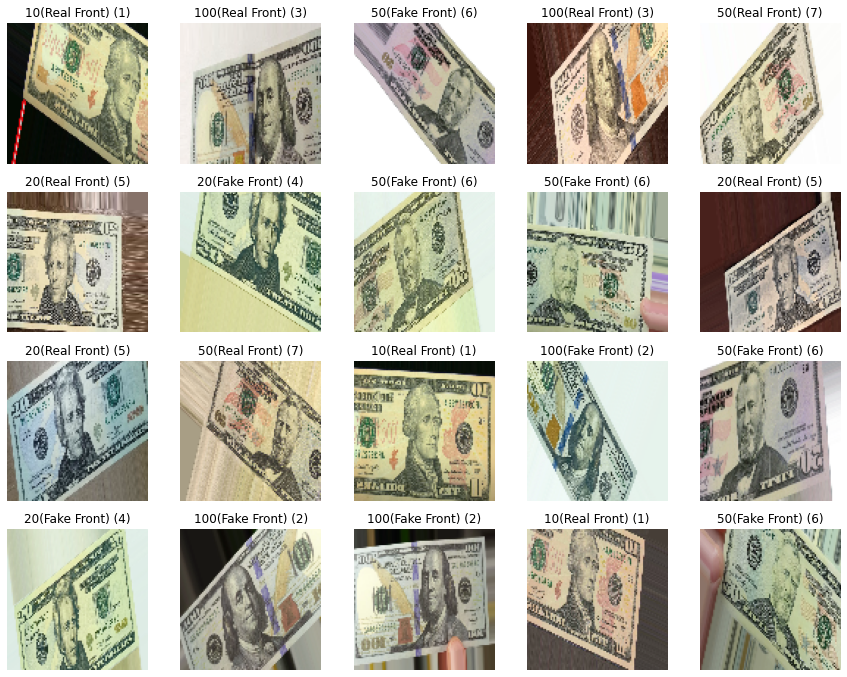

In [25]:
# Show sample of images.
plt.figure(figsize=(15, 15))
images = []
labels = []
for itr in train_generator.next():
    for i in range(20):
        if len(images) < 20:
            images.append(itr[i].astype("uint8"))
        else:
            labels.append(list(itr[i]).index(1))

for i in range(len(images)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]].replace('_',' ') +' ('+str(int(labels[i]))+')')
    plt.axis("off")

## Instantiating the VGG19 convolutional base

In [14]:
VGG19_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

conv_base = VGG19_base

In [15]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

## Instantiating a densely connected classifier

### Layer Structure 

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 21,206,344
Trainable params: 21,206,344
Non-trainable params: 0
_________________________________________________________________


In [18]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 36


In [19]:
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 21,206,344
Trainable params: 1,181,960
Non-trainable params: 20,024,384
_________________________________________________________________


In [21]:
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights after freezing the conv base: 4


## Configuring the model for training 

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Callbacks 

In [23]:
# Prepare a directory to store all the checkpoints.
checkpoint_dir = 'chkpnt'

In [24]:
keras_callbacks = EarlyStopping(monitor='val_loss', patience=5, mode='auto', 
                                 min_delta = 0, verbose=1)

## Fitting the model 

In [26]:
history = model.fit(
      train_generator,
      steps_per_epoch=n_steps_per_epoch,
      epochs=nb_epochs,
      validation_data=validation_generator,
      validation_steps=n_validation_steps,
      callbacks=keras_callbacks)

Epoch 1/5
198/198 [==============================] - 869s 4s/step - loss: 1.3847 - accuracy: 0.8846 - val_loss: 0.2908 - val_accuracy: 0.9453
Epoch 2/5
198/198 [==============================] - 922s 5s/step - loss: 0.1161 - accuracy: 0.9751 - val_loss: 0.1305 - val_accuracy: 0.9757
Epoch 3/5
198/198 [==============================] - 913s 5s/step - loss: 0.0658 - accuracy: 0.9862 - val_loss: 0.1335 - val_accuracy: 0.9777
Epoch 4/5
198/198 [==============================] - 920s 5s/step - loss: 0.0656 - accuracy: 0.9902 - val_loss: 0.0964 - val_accuracy: 0.9824
Epoch 5/5
198/198 [==============================] - 862s 4s/step - loss: 0.1228 - accuracy: 0.9817 - val_loss: 0.1116 - val_accuracy: 0.9807


In [29]:
#save the model
import os.path
if os.path.isfile('model/banknote_auth_tl.h5') is False:
    model.save('model/banknote_auth_tl.h5')

## Visualize training results¶

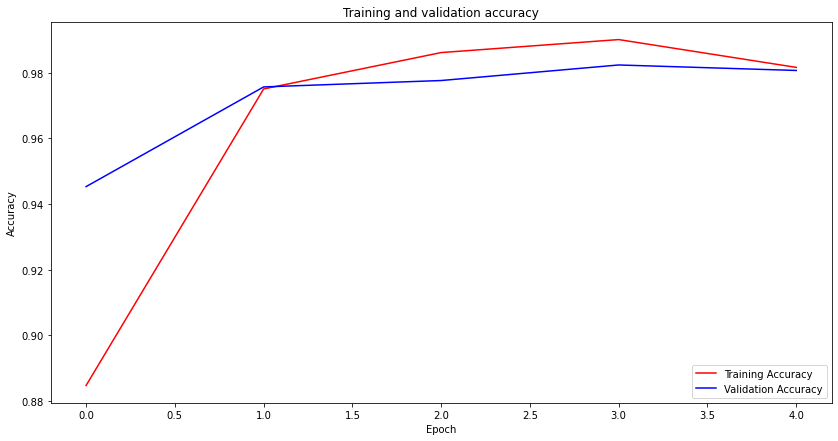

In [27]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

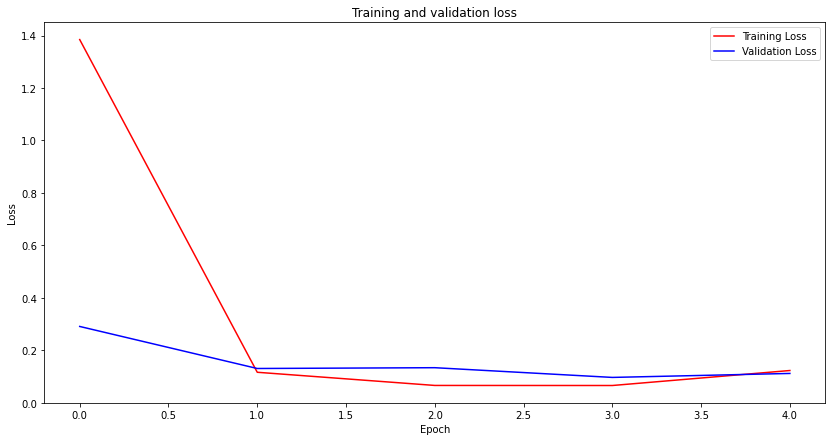

In [28]:
fig2 = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [12]:
from keras import models    
model = models.load_model('model/banknote_auth_tl.h5', compile = False)

In [13]:
test_generator.classes

array([0, 0, 0, ..., 7, 7, 7])

In [14]:
predictions = model.predict(x=test_generator, verbose=0)
np.round(predictions)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [15]:
cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))

In [16]:
#overall accuracy of model
y_true=test_generator.labels
y_pred=np.argmax(predictions, axis=-1)
from sklearn import metrics
print("Accuracy = ", metrics.accuracy_score(y_true, y_pred))

Accuracy =  0.9873556899395272


In [20]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.magma):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        print("Normalized confusion matrix")
    else:
        cm=cm
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
test_generator.class_indices

{'10(Fake_Front)': 0,
 '10(Real_Front)': 1,
 '100(Fake_Front)': 2,
 '100(Real_Front)': 3,
 '20(Fake_Front)': 4,
 '20(Real_Front)': 5,
 '50(Fake_Front)': 6,
 '50(Real_Front)': 7}

Confusion matrix, without normalization
[[225   0   0   0   3   0   1   0]
 [  1 225   0   0   0   2   0   0]
 [  1   0 228   0   0   0   0   0]
 [  0   1   2 219   1   0   0   0]
 [  1   0   0   0 225   0   1   0]
 [  0   0   0   0   0 224   0   1]
 [  0   0   0   0   0   1 221   5]
 [  0   0   0   0   1   0   1 229]]


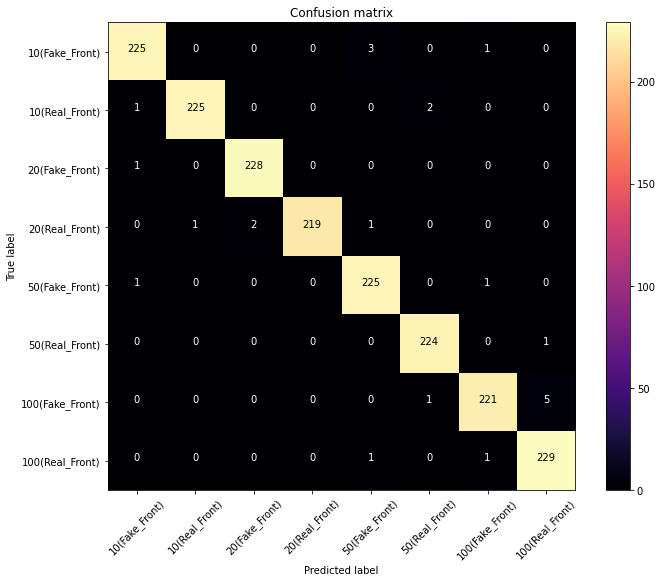

In [22]:
fig1 = plt.figure(figsize=(10,8))
cm_plot_labels = ['10(Fake_Front)','10(Real_Front)','20(Fake_Front)','20(Real_Front)','50(Fake_Front)','50(Real_Front)','100(Fake_Front)','100(Real_Front)']
plot_confusion_matrix(cm=cm, classes= cm_plot_labels, title= 'Confusion matrix')
plt.show()

## Predictions made by the model

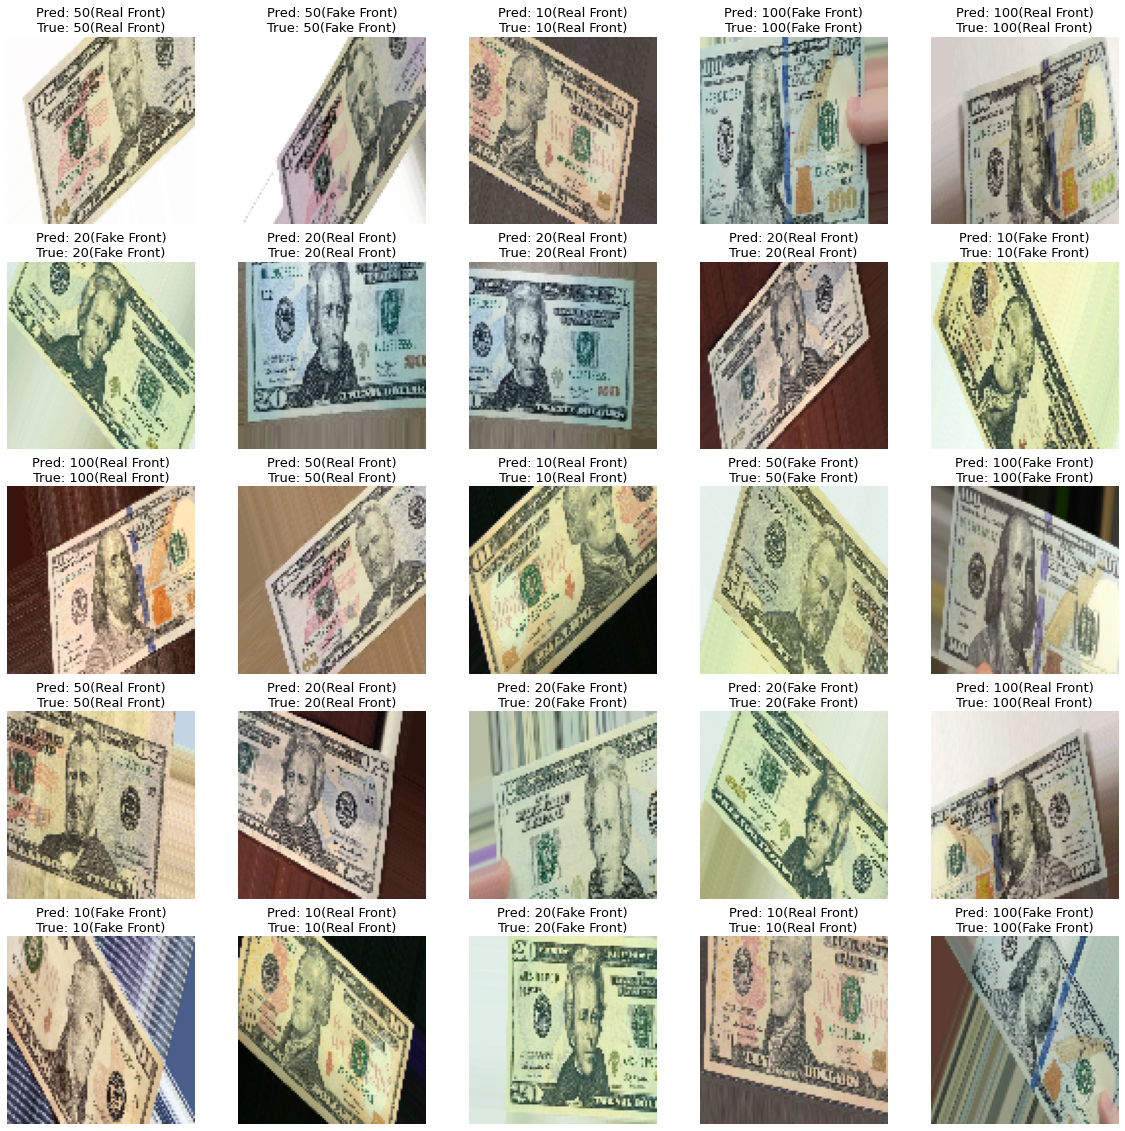

In [46]:
test_generator.reset()
test_generator.shuffle = True

#image previews
plt.figure(figsize=(20, 20))
images = []
labels_pred = []
labels_true = []
for itr in test_generator.next():
    for i in range(25):
        if len(images) < 25:
            images.append(itr[i].astype("uint8"))
            y_proba = model.predict(np.array([itr[i]]))
            y_pred = np.argmax(y_proba,axis=1)[0]
            labels_pred.append(y_pred)
        else:
            labels_true.append(list(itr[i]).index(1))
    

for i in range(len(images)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])    
    title = 'Pred: ' + class_names[labels_pred[i]].replace('_',' ') +'\n' +'True: ' + class_names[labels_true[i]].replace('_',' ') 
    
    
    plt.title(title,fontsize= 13, pad=5)
    plt.axis("off")
#     plt.subplots_adjust(left=None, bottom=0.1, right=None, top=1, wspace=None, hspace=None)